In [13]:
# Import needed packages
"""Customer Segmentation with K-Means Clustering"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [14]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [15]:

# Configuration
CONFIG = {
    "customer_file_path": "Customer_Feedback_Data.csv",
    "product_file_path": "Product_Offering_Data.csv",
    "transaction_file_path": "Transaction_Data.csv",
    "optimal_k": 3,
    "dendrogram_sample_size": 500,
    "random_state": 42
}

In [9]:
# Function to load data
def load_data(file_path):
    """Load CSV data with error handling"""
    try:
        df = pd.read_csv(file_path)
        logging.info("Loaded data from: %s", file_path)
        return df
    except FileNotFoundError:
        logging.error("File not found: %s", file_path)
        raise
    except Exception as e:
        logging.error("Error loading %s: %s", file_path, str(e))
        raise

In [19]:
# Function to clean column names
def clean_column_names(df):
    """Standardize column names"""
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df

In [21]:
# Function to handle missing data
def handle_missing_data(df, column, strategy='mean'):
    """Handle missing values in specified column"""
    try:
        if strategy == 'mean':
            df[column] = df[column].fillna(df[column].mean())
        elif strategy == 'mode':
            df[column] = df[column].fillna(df[column].mode()[0])
        elif strategy == 'unknown':
            df[column] = df[column].fillna('Unknown')
        logging.info("Handled missing values in %s using %s strategy", column, strategy)
        return df
    except Exception as e:
        logging.error("Error handling missing data: %s", str(e))
        raise

In [23]:
# Function to normalize data
def normalize_data(df, column, scaler_type='minmax'):
    """Normalize specified column using selected scaler"""
    try:
        if scaler_type == 'minmax':
            scaler = MinMaxScaler()
        elif scaler_type == 'standard':
            scaler = StandardScaler()
        df[f"{column}_scaled"] = scaler.fit_transform(df[[column]])
        logging.info("Normalized %s using %s scaler", column, scaler_type)
        return df, scaler
    except Exception as e:
        logging.error("Error normalizing data: %s", str(e))
        raise


In [49]:
# Function to merge data
def merge_data(df1, df2, on_column, how='inner'):
    """Merge two DataFrames on specified column."""
    merged_df = df1.merge(df2, on=on_column, how=how)
    logging.info(f"DataFrames merged on '{on_column}' column.")
    return merged_df

In [25]:
# Plot the dendogram
def plot_dendrogram(data, features, method='ward'):
    """Plot hierarchical clustering dendrogram"""
    try:
        np.random.seed(CONFIG["random_state"])
        subsample_size = min(CONFIG["dendrogram_sample_size"], len(data))
        subsample = data[features].sample(n=subsample_size)
        
        Z = linkage(subsample, method=method, metric='euclidean')
        
        plt.figure(figsize=(15, 7))
        dendrogram(Z, truncate_mode='lastp', p=15, show_leaf_counts=True)
        plt.title(f'Hierarchical Clustering Dendrogram ({method.title()} Linkage)')
        plt.xlabel('Customer Index (Subsampled)')
        plt.ylabel('Distance')
        plt.axhline(y=3.0, color='r', linestyle='--', label='Suggested Cutoff')
        plt.legend()
        plt.show()
        
    except Exception as e:
        logging.error("Dendrogram error: %s", str(e))
        raise


In [33]:
# Explain clustering results
def explain_clustering_results(data, features, silhouette, calinski):
    """Generate cluster analysis report"""
    try:
        # Cluster statistics
        cluster_stats = data.groupby('cluster').agg({
            'transaction_amount_scaled': ['mean', 'std'],
            'satisfaction_score': ['mean', 'std'],
            'transaction_amount': ['mean', 'median', 'max']
        }).reset_index()

        # Visualization
        plt.figure(figsize=(18, 12))

        # Cluster distribution
        plt.subplot(2, 2, 1)
        cluster_dist = data['cluster'].value_counts().sort_index()
        sns.barplot(x=cluster_dist.index, y=cluster_dist.values, palette='viridis')
        plt.title('Customer Distribution Across Clusters')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Customers')
        
        # Transaction amounts
        plt.subplot(2, 2, 2)
        sns.boxplot(x='cluster', y='transaction_amount', data=data, palette='viridis')
        plt.title('Transaction Amount Distribution by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Amount ($)')
        
        # Satisfaction scores
        plt.subplot(2, 2, 3)
        sns.violinplot(x='cluster', y='satisfaction_score', data=data, palette='viridis')
        plt.title('Satisfaction Score Distribution by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Satisfaction Score')
        
        # Scatter plot with centroids
        plt.subplot(2, 2, 4)
        sns.scatterplot(
            x='satisfaction_score',
            y='transaction_amount_scaled',
            hue='cluster',
            data=data,
            palette='viridis',
            alpha=0.7
        )
        centroids = data.groupby('cluster')[features].mean()
        plt.scatter(
            centroids['satisfaction_score'],
            centroids['transaction_amount_scaled'],
            marker='X',
            s=200,
            c='red',
            edgecolor='black',
            label='Centroids'
        )
        plt.title('Customer Clusters with Centroids')
        plt.xlabel('Satisfaction Score')
        plt.ylabel('Scaled Transaction Amount')
        
        plt.tight_layout()
        plt.show()

        # Print report
        print(f"""
        {'='*60}
        CLUSTERING PERFORMANCE
        {'='*60}
        Silhouette Score: {silhouette:.3f} (0-1 scale)
        Calinski-Harabasz Score: {calinski:.1f} (Higher=Better)
        
        {'='*60}
        CLUSTER STATISTICS
        {'='*60}
        {cluster_stats.to_string(index=False)}
        
        {'='*60}
        STRATEGIC RECOMMENDATIONS
        {'='*60}
        1. High Satisfaction/Medium Spend: Retention focus
        2. Low Satisfaction/Varied Spend: Churn prevention
        3. Special Cases: Investigate anomalies""")

    except Exception as e:
        logging.error("Results explanation error: %s", str(e))
        raise

In [35]:
# Main Function
def main():
    """Main analysis workflow"""
    try:
        # Load and clean data
        customer = load_data(CONFIG["customer_file_path"])
        product = load_data(CONFIG["product_file_path"])
        transaction = load_data(CONFIG["transaction_file_path"])

        # Clean column names
        customer = clean_column_names(customer)
        product = clean_column_names(product)
        transaction = clean_column_names(transaction)

        # Handle missing data
        customer = handle_missing_data(customer, 'satisfaction_score', 'mode')
        transaction = handle_missing_data(transaction, 'transaction_amount', 'mean')
        product = handle_missing_data(product, 'target_age_group', 'unknown')

        # Feature engineering
        transaction, scaler = normalize_data(transaction, 'transaction_amount', 'minmax')

        # Merge product data
        if 'product_id' in transaction.columns and 'product_id' in product.columns:
            transaction = transaction.merge(
                product[['product_id', 'product_type']],
                on='product_id',
                how='left'
            )
            transaction = handle_missing_data(transaction, 'product_type', 'unknown')
        else:
            logging.warning("Skipping product data merge - missing product_id columns")

        # Prepare clustering data
        clustering_data = transaction.merge(
            customer[['customer_id', 'satisfaction_score']],
            on='customer_id',
            how='inner'
        )

        # Hierarchical clustering visualization
        plot_dendrogram(
            clustering_data,
            ['transaction_amount_scaled', 'satisfaction_score']
        )

        # K-Means clustering
        features = ['transaction_amount_scaled', 'satisfaction_score']
        kmeans = KMeans(
            n_clusters=CONFIG["optimal_k"],
            random_state=CONFIG["random_state"]
        )
        clustering_data['cluster'] = kmeans.fit_predict(clustering_data[features])

        # Add original transaction amounts
        clustering_data['transaction_amount'] = scaler.inverse_transform(
            clustering_data[['transaction_amount_scaled']]
        )

        # Evaluate clustering
        silhouette = silhouette_score(clustering_data[features], clustering_data['cluster'])
        calinski = calinski_harabasz_score(clustering_data[features], clustering_data['cluster'])

        # Generate report
        explain_clustering_results(clustering_data, features, silhouette, calinski)

        # Save results
        clustering_data.to_csv('segmented_customers.csv', index=False)
        logging.info("Saved clustering results to segmented_customers.csv")

    except Exception as e:
        logging.error("Analysis failed: %s", str(e))
        raise

2025-03-14 17:31:44,146 - INFO - Loaded data from: Customer_Feedback_Data.csv
2025-03-14 17:31:44,151 - INFO - Loaded data from: Product_Offering_Data.csv
2025-03-14 17:31:44,163 - INFO - Loaded data from: Transaction_Data.csv
2025-03-14 17:31:44,167 - INFO - Handled missing values in satisfaction_score using mode strategy
2025-03-14 17:31:44,169 - INFO - Handled missing values in transaction_amount using mean strategy
2025-03-14 17:31:44,171 - INFO - Handled missing values in target_age_group using unknown strategy
2025-03-14 17:31:44,177 - INFO - Normalized transaction_amount using minmax scaler
2025-03-14 17:31:44,178 - WARNING - Skipping product data merge - missing product_id columns


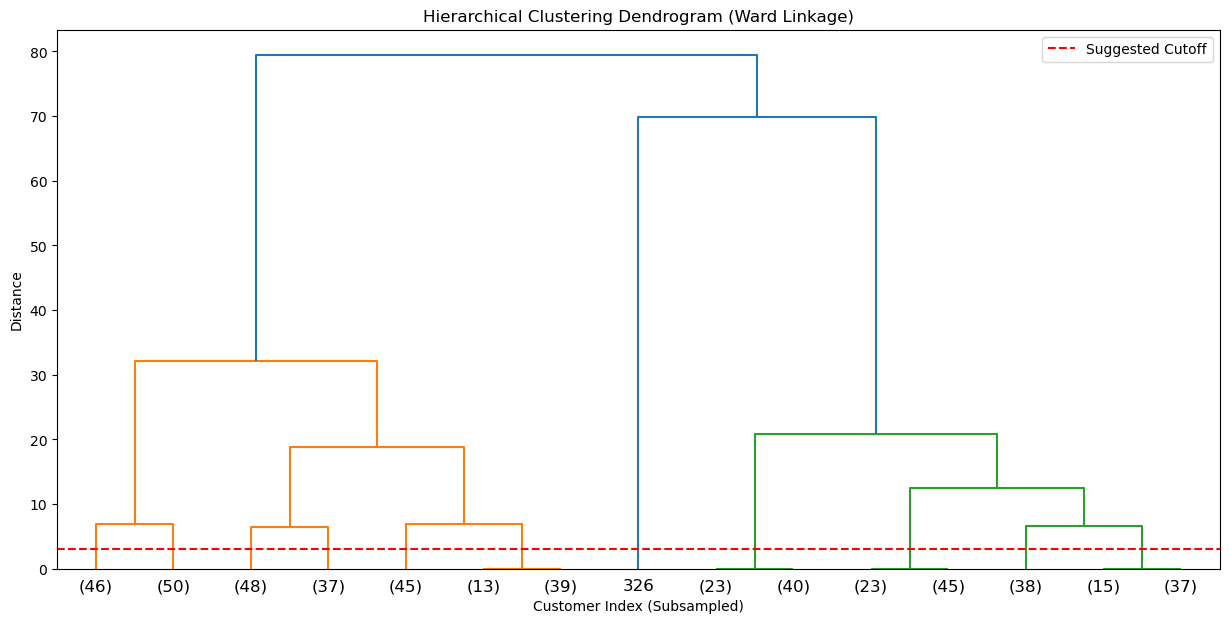

2025-03-14 17:31:57,099 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\jonad\AppData\Local\Temp\ipykernel_25336\4035353165.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_dist.index, y=cluster_dist.values, palette='viridis')
2025-03-14 17:31:57,107 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-14 17:31:57,162 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:

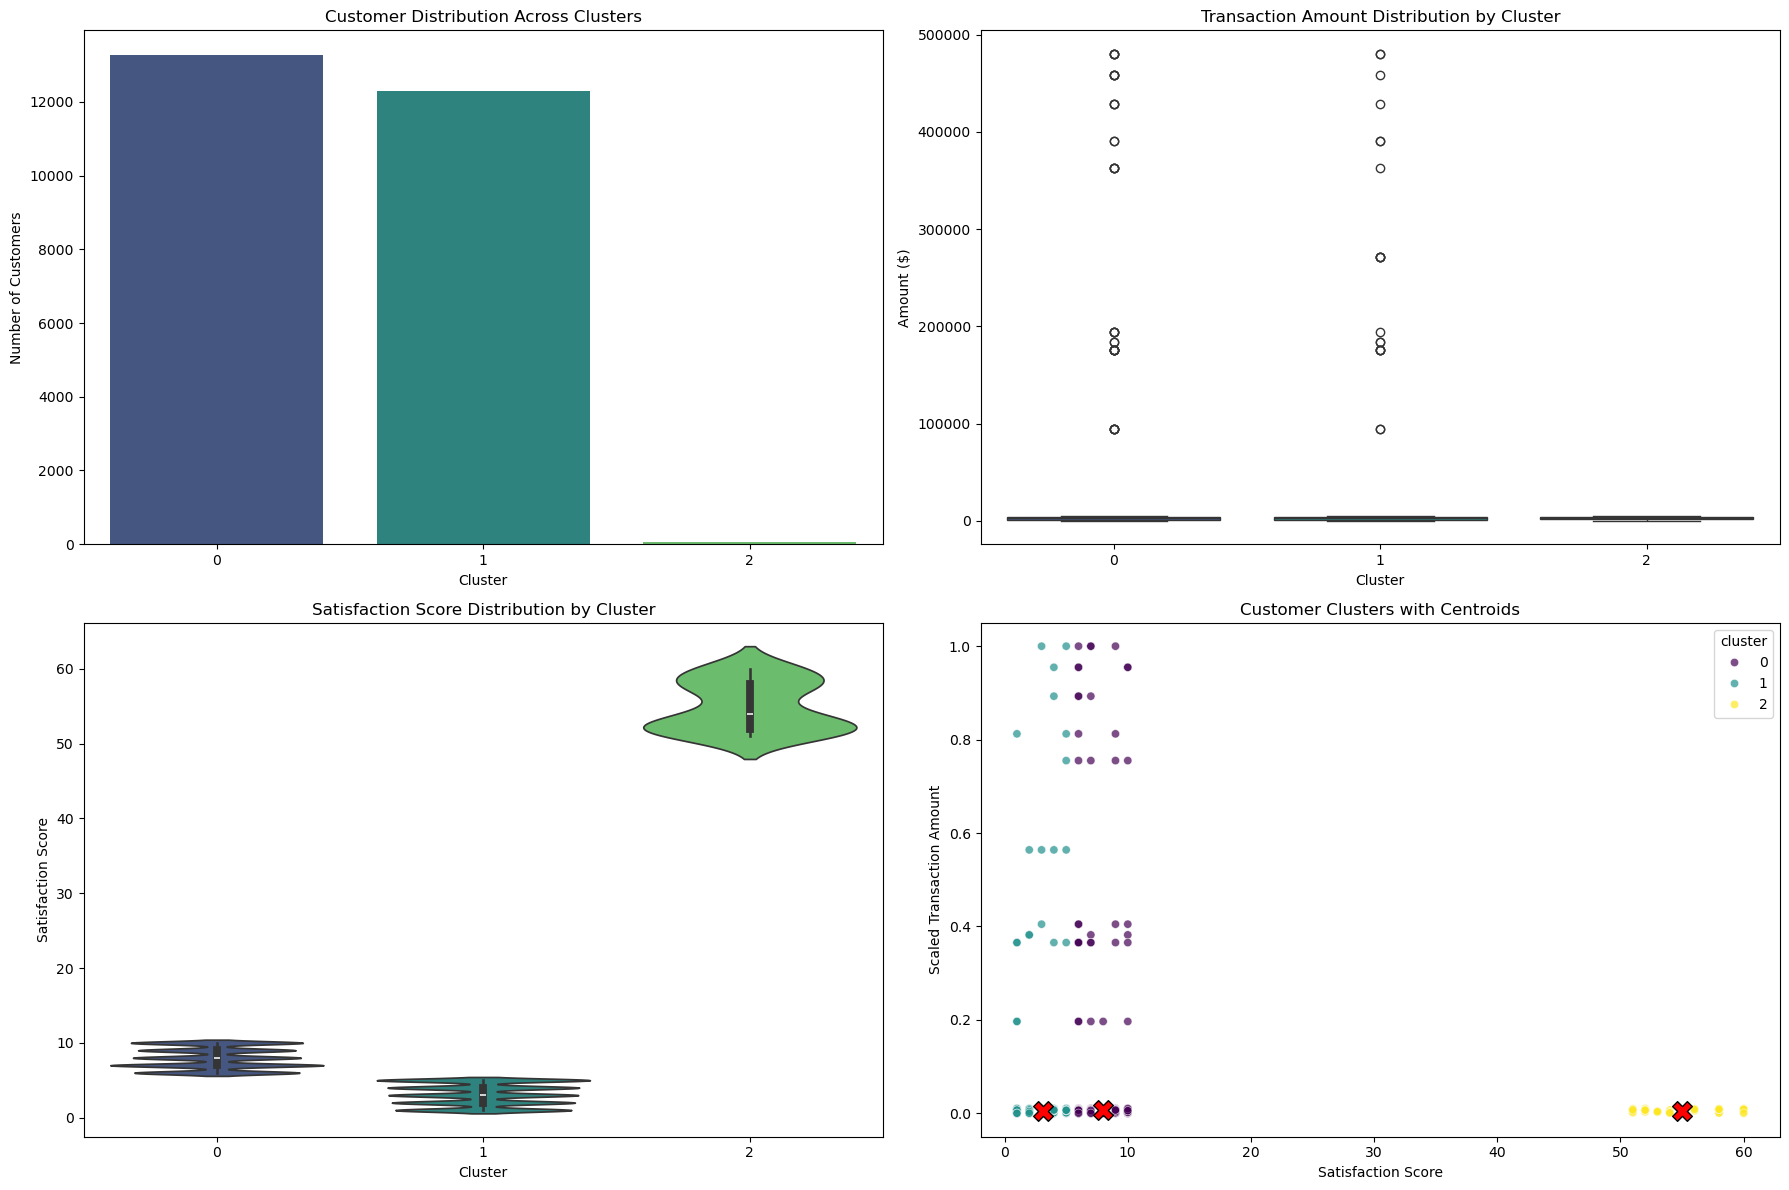

2025-03-14 17:31:59,616 - INFO - Saved clustering results to segmented_customers.csv



        CLUSTERING PERFORMANCE
        Silhouette Score: 0.639 (0-1 scale)
        Calinski-Harabasz Score: 67962.2 (Higher=Better)
        
        CLUSTER STATISTICS
        cluster transaction_amount_scaled          satisfaction_score          transaction_amount                
                             mean      std               mean      std               mean median      max
      0                  0.006702 0.034262           7.952324 1.400749        3228.955295 2493.0 480300.0
      1                  0.006093 0.025377           3.087020 1.420036        2936.317782 2539.5 480300.0
      2                  0.005774 0.003066          54.980000 3.322711        2783.160000 2761.5   4935.0
        
        STRATEGIC RECOMMENDATIONS
        1. High Satisfaction/Medium Spend: Retention focus
        2. Low Satisfaction/Varied Spend: Churn prevention
        3. Special Cases: Investigate anomalies


In [41]:
#Run the main function
if __name__ == "__main__":
    main()